# Website Credibility Classification - Realistic Modeling

**Objective:** Build a machine learning model to classify websites as trusted or untrusted based on metadata features.

**Approach:**
- Use ALL available labeled data (500+ samples)
- Stratified k-fold cross-validation (k=5)
- Statistical confidence intervals
- Multiple model comparison

## 1. Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available")

print("✓ Setup complete")

✓ XGBoost available
✓ Setup complete


## 2. Load and Prepare Data

In [6]:
# Load datasets
trusted_sources = pd.read_csv('trusted_sources_original.csv')
untrusted_sources = pd.read_csv('untrusted_sources.csv')
metadata = pd.read_csv('website_metadata_examples.csv')

print(f"Trusted sources: {len(trusted_sources)} records")
print(f"Untrusted sources: {len(untrusted_sources)} records")
print(f"Metadata: {len(metadata)} records")

Trusted sources: 274 records
Untrusted sources: 243 records
Metadata: 700 records


In [7]:
# Create labeled datasets
trusted_labeled = trusted_sources[['domain']].copy()
trusted_labeled['credibility_label'] = 1

untrusted_labeled = untrusted_sources[['domain']].copy()
untrusted_labeled['credibility_label'] = 0

# Combine labels
source_labels = pd.concat([trusted_labeled, untrusted_labeled], ignore_index=True)

print(f"Total labeled domains: {len(source_labels)}")
print(f"Unique domains: {source_labels['domain'].nunique()}")
print(f"\nClass distribution:")
print(source_labels['credibility_label'].value_counts())

Total labeled domains: 517
Unique domains: 514

Class distribution:
credibility_label
1    274
0    243
Name: count, dtype: int64


In [4]:
# Merge metadata with labels (use ALL labeled records)
df = metadata.merge(source_labels, on='domain', how='inner')

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(df)}")
print(f"Unique domains: {df['domain'].nunique()}")
print(f"\nClass distribution:")
print(df['credibility_label'].value_counts())
print(f"\nClass balance:")
print(df['credibility_label'].value_counts(normalize=True).round(3))
print(f"{'='*60}")


DATASET SUMMARY
Total samples: 719
Unique domains: 56

Class distribution:
credibility_label
0    414
1    305
Name: count, dtype: int64

Class balance:
credibility_label
0    0.576
1    0.424
Name: proportion, dtype: float64


In [5]:
# Step 2: Generate realistic synthetic websites + edge cases
np.random.seed(42)

def generate_synthetic_websites(n_samples, credibility_label, existing_df, edge_case=False):
    """Generate realistic synthetic website metadata"""
    
    synthetic_data = []
    label_name = "trusted" if credibility_label == 1 else "untrusted"
    
    for i in range(n_samples):
        # Generate domain name
        if credibility_label == 1:
            # Trusted sources: professional TLDs, established names
            tld = np.random.choice(['.com', '.org', '.edu', '.gov', '.net'], p=[0.4, 0.3, 0.15, 0.1, 0.05])
            prefix = np.random.choice(['news', 'times', 'press', 'daily', 'post', 'journal', 'herald', 'tribune'])
            suffix = np.random.choice(['', 'central', 'network', 'today', 'weekly', str(np.random.randint(1,100))])
            domain = f"{prefix}{suffix}{tld}".replace(" ", "")
        else:
            # Untrusted sources: misleading names, unusual TLDs
            tld = np.random.choice(['.com', '.news', '.info', '.co', '.net'], p=[0.5, 0.2, 0.15, 0.1, 0.05])
            prefix = np.random.choice(['real', 'true', 'patriot', 'freedom', 'alert', 'wake', 'natural', 'truth'])
            suffix = np.random.choice(['news', 'daily', 'report', 'feed', 'central', 'insider', str(np.random.randint(1,100))])
            domain = f"{prefix}{suffix}{tld}".replace(" ", "")
        
        # Quality factor determines overall metadata quality
        if edge_case:
            # Edge cases: make trusted sites look suspicious or untrusted sites look professional
            if credibility_label == 1:
                # Trusted but poor metadata
                quality = np.random.beta(2, 4)  # Skewed toward low quality
            else:
                # Untrusted but good metadata
                quality = np.random.beta(6, 2)  # Skewed toward high quality
        else:
            # Normal cases
            if credibility_label == 1:
                quality = np.random.beta(7, 2)  # Skewed toward high quality
            else:
                quality = np.random.beta(2, 5)  # Skewed toward low quality
        
        # Generate metadata based on quality factor
        record = {
            'domain': f"synthetic_{'edge_' if edge_case else ''}{label_name}_{i:03d}_{domain}",
            'credibility_label': credibility_label,
            
            # Security features (edge cases flip expectations)
            'has_https': 'Yes' if np.random.random() < (0.95 if credibility_label == 1 else 0.70) * (0.7 if edge_case else 1.0) else 'No',
            'ssl_valid': 'Yes' if np.random.random() < (0.92 if credibility_label == 1 else 0.60) * (0.8 if edge_case else 1.0) else 'No',
            'ssl_issuer': np.random.choice(
                ["Let's Encrypt", 'DigiCert', 'GlobalSign', 'Comodo', 'GeoTrust'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ["Let's Encrypt", 'Self-signed', 'Unknown', 'Cloudflare']
            ),
            'tls_version': np.random.choice(
                ['TLS 1.3', 'TLS 1.2'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['TLS 1.2', 'TLS 1.1', 'TLS 1.0', 'none']
            ),
            'certificate_type': np.random.choice(
                ['EV', 'OV', 'DV'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['DV', 'none', 'self_signed']
            ),
            
            # Domain characteristics
            'domain_age_years': np.random.exponential(20 if credibility_label == 1 else 5) if not edge_case else np.random.exponential(8),
            'domain_age_bucket': None,  # Will be calculated
            'domain_registrar': np.random.choice(
                ['CSC Corporate', 'Network Solutions', 'MarkMonitor', 'Verisign'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['Namecheap', 'GoDaddy', 'eNom', 'Unknown']
            ),
            'whois_privacy_enabled': np.random.choice([True, False], p=[0.3, 0.7] if (credibility_label == 1 and not edge_case) else [0.8, 0.2]),
            
            # Performance
            'page_load_time_sec': np.random.gamma(2, 0.5 if (credibility_label == 1 and not edge_case) else 1.5),
            'redirect_count': np.random.poisson(0.5 if (credibility_label == 1 and not edge_case) else 2),
            'server_response_code': np.random.choice([200, 301, 302, 404], p=[0.95, 0.03, 0.01, 0.01] if (credibility_label == 1 and not edge_case) else [0.85, 0.05, 0.05, 0.05]),
            
            # Content quality (edge cases flip the patterns)
            'ads_density_score': np.random.beta(2, 5 if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else 2),
            'external_links_count': int(np.random.gamma(3, 15 if (credibility_label == 1 and not edge_case) else 30)),
            'popups_present': np.random.choice(['No', 'Yes'], p=[0.90, 0.10] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.50, 0.50]),
            
            # Infrastructure
            'server_location': np.random.choice(
                ['USA', 'UK', 'Canada', 'EU', 'France'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['USA', 'Offshore', 'Russia', 'Unknown', 'Asia']
            ),
            'hosting_type': np.random.choice(
                ['enterprise', 'cloud', 'dedicated'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['shared', 'cloud', 'offshore']
            ),
            'cdn_used': np.random.choice(['yes', 'no'], p=[0.80, 0.20] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.40, 0.60]),
            
            # Policies and transparency
            'contact_info_available': np.random.choice([True, False], p=[0.95, 0.05] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.50, 0.50]),
            'privacy_policy_exists': np.random.choice([True, False], p=[0.95, 0.05] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.60, 0.40]),
            'terms_of_service_exists': np.random.choice([True, False], p=[0.95, 0.05] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.60, 0.40]),
            
            # Social and engagement
            'social_media_presence': np.random.choice(['high', 'medium', 'low'], p=[0.6, 0.3, 0.1] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.2, 0.4, 0.4]),
            'content_update_frequency': np.random.choice(
                ['hourly', 'daily', 'weekly'] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case)
                else ['daily', 'weekly', 'irregular', 'monthly']
            ),
            
            # Technical
            'mobile_responsive': np.random.choice(['Yes', 'No', 'Partial'], p=[0.85, 0.05, 0.10] if (credibility_label == 1 and not edge_case) or (credibility_label == 0 and edge_case) else [0.60, 0.25, 0.15]),
        }
        
        # Calculate domain age bucket
        age = record['domain_age_years']
        if age < 1:
            record['domain_age_bucket'] = '0-1y'
        elif age < 5:
            record['domain_age_bucket'] = '1-5y'
        elif age < 10:
            record['domain_age_bucket'] = '5-10y'
        elif age < 20:
            record['domain_age_bucket'] = '10-20y'
        else:
            record['domain_age_bucket'] = '20y+'
        
        synthetic_data.append(record)
    
    return pd.DataFrame(synthetic_data)

# Generate synthetic data
print("\\nGenerating synthetic websites...\\n")

# Normal synthetic samples (70% of needed)
normal_trusted = int(trusted_needed * 0.7)
normal_untrusted = int(untrusted_needed * 0.7)

# Edge case samples (30% of needed)
edge_trusted = trusted_needed - normal_trusted
edge_untrusted = untrusted_needed - normal_untrusted

synthetic_trusted_normal = generate_synthetic_websites(normal_trusted, 1, df_unique, edge_case=False)
synthetic_trusted_edge = generate_synthetic_websites(edge_trusted, 1, df_unique, edge_case=True)

synthetic_untrusted_normal = generate_synthetic_websites(normal_untrusted, 0, df_unique, edge_case=False)
synthetic_untrusted_edge = generate_synthetic_websites(edge_untrusted, 0, df_unique, edge_case=True)

print(f"Generated {normal_trusted} normal trusted websites")
print(f"Generated {edge_trusted} edge case trusted websites (poor metadata)")
print(f"Generated {normal_untrusted} normal untrusted websites")
print(f"Generated {edge_untrusted} edge case untrusted websites (good metadata)")

# Combine all data
df_final = pd.concat([
    df_unique,
    synthetic_trusted_normal,
    synthetic_trusted_edge,
    synthetic_untrusted_normal,
    synthetic_untrusted_edge
], ignore_index=True)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

edge_case_count = edge_trusted + edge_untrusted
total_synthetic = normal_trusted + edge_trusted + normal_untrusted + edge_untrusted

print(f"\\n{'='*60}")
print("FINAL DATASET")
print(f"{'='*60}")
print(f"Total samples: {len(df_final)}")
print(f"  Real websites: {len(df_unique)} ({len(df_unique)/len(df_final)*100:.1f}%)")
print(f"  Synthetic websites: {total_synthetic} ({total_synthetic/len(df_final)*100:.1f}%)")
print(f"    - Normal: {normal_trusted + normal_untrusted} ({(normal_trusted + normal_untrusted)/len(df_final)*100:.1f}%)")
print(f"    - Edge cases: {edge_case_count} ({edge_case_count/len(df_final)*100:.1f}%)")
print(f"\\nClass distribution:")
print(df_final['credibility_label'].value_counts())
print(f"\\nClass balance:")
print(df_final['credibility_label'].value_counts(normalize=True).round(3))
print(f"{'='*60}")

\nGenerating synthetic websites...\n


NameError: name 'trusted_needed' is not defined

## 3. Feature Engineering

In [ ]:
# Define feature columns (exclude perfect predictors and identifiers)
excluded_features = [
    'domain',  # identifier
    'credibility_label',  # target
    'security_headers_score',  # perfect predictor (if exists)
    'javascript_obfuscation_score',  # perfect predictor (if exists)
    'malware_flag_score'  # potential leakage
]

# Get all available features
feature_cols = [col for col in df_final.columns if col not in excluded_features]

print(f"Total features: {len(feature_cols)}")
print(f"\\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Total features: 24
\nFeature list:
   1. has_https
   2. domain_age_years
   3. ssl_valid
   4. ssl_issuer
   5. redirect_count
   6. page_load_time_sec
   7. server_location
   8. server_response_code
   9. ads_density_score
  10. external_links_count
  11. social_media_presence
  12. contact_info_available
  13. privacy_policy_exists
  14. terms_of_service_exists
  15. whois_privacy_enabled
  16. domain_registrar
  17. content_update_frequency
  18. mobile_responsive
  19. tls_version
  20. certificate_type
  21. hosting_type
  22. cdn_used
  23. popups_present
  24. domain_age_bucket


In [ ]:
# Prepare features and target
X = df_final[feature_cols].copy()
y = df_final['credibility_label'].copy()

# Check for missing values
missing_summary = X.isnull().sum()
if missing_summary.sum() > 0:
    print("Missing values found:")
    print(missing_summary[missing_summary > 0])
    print()
else:
    print("✓ No missing values\\n")

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

✓ No missing values\n
Numeric features: 6
Categorical features: 18


In [ ]:
# Handle missing values
for col in numeric_cols:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        X[col].fillna('unknown', inplace=True)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nFinal feature matrix shape: {X_encoded.shape}")
print(f"Features after encoding: {X_encoded.shape[1]}")
print(f"Samples: {X_encoded.shape[0]}")


Final feature matrix shape: (240, 82)
Features after encoding: 82
Samples: 240


## 4. Model Training with Cross-Validation

In [ ]:
# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

print("Cross-validation setup:")
print(f"  Strategy: Stratified K-Fold")
print(f"  Folds: 5")
print(f"  Metrics: Accuracy, Precision, Recall, F1, ROC-AUC")
print(f"\nEach fold: ~{len(X_encoded)//5} test samples, ~{len(X_encoded)*4//5} training samples")

Cross-validation setup:
  Strategy: Stratified K-Fold
  Folds: 5
  Metrics: Accuracy, Precision, Recall, F1, ROC-AUC

Each fold: ~48 test samples, ~192 training samples


## 4A. Train/Test Split Evaluation

In [ ]:
# Traditional train/test split (80/20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test Split:")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"  Test samples: {len(X_test)} ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"\\nTraining class distribution:")
print(y_train.value_counts())
print(f"\\nTest class distribution:")
print(y_test.value_counts())

Train/Test Split:
  Training samples: 192 (80.0%)
  Test samples: 48 (20.0%)
\nTraining class distribution:
credibility_label
0    96
1    96
Name: count, dtype: int64
\nTest class distribution:
credibility_label
0    24
1    24
Name: count, dtype: int64


In [ ]:
# Train models with simple train/test split
results_split = {}

def train_and_evaluate(name, model, X_train, X_test, y_train, y_test, scaled=False):
    """Train and evaluate a model using train/test split"""
    import time
    
    if scaled:
        scaler_split = StandardScaler()
        X_tr = scaler_split.fit_transform(X_train)
        X_te = scaler_split.transform(X_test)
    else:
        X_tr = X_train
        X_te = X_test
    
    # Train
    start = time.time()
    model.fit(X_tr, y_train)
    train_time = time.time() - start
    
    # Predict
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    results_split[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'train_time': train_time,
        'model': model
    }
    
    print(f"\\n{name}:")
    print(f"  Accuracy:  {results_split[name]['accuracy']:.4f}")
    print(f"  Precision: {results_split[name]['precision']:.4f}")
    print(f"  Recall:    {results_split[name]['recall']:.4f}")
    print(f"  F1-Score:  {results_split[name]['f1']:.4f}")
    if y_pred_proba is not None:
        print(f"  ROC-AUC:   {results_split[name]['roc_auc']:.4f}")
    print(f"  Train time: {train_time:.3f}s")

print("\\n" + "="*70)
print("TRAIN/TEST SPLIT EVALUATION (80/20)")
print("="*70)

\n======================================================================
TRAIN/TEST SPLIT EVALUATION (80/20)


In [ ]:
# Train all models with train/test split
lr_split = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', solver='lbfgs')
train_and_evaluate('Logistic Regression', lr_split, X_train, X_test, y_train, y_test, scaled=True)

dt_split = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=42, class_weight='balanced')
train_and_evaluate('Decision Tree', dt_split, X_train, X_test, y_train, y_test, scaled=False)

rf_split = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42, class_weight='balanced', n_jobs=-1)
train_and_evaluate('Random Forest', rf_split, X_train, X_test, y_train, y_test, scaled=False)

gb_split = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
train_and_evaluate('Gradient Boosting', gb_split, X_train, X_test, y_train, y_test, scaled=False)

if XGBOOST_AVAILABLE:
    import xgboost as xgb
    scale_pos_weight_split = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_split = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=scale_pos_weight_split, random_state=42, eval_metric='logloss', use_label_encoder=False)
    train_and_evaluate('XGBoost', xgb_split, X_train, X_test, y_train, y_test, scaled=False)

\nLogistic Regression:
  Accuracy:  0.8333
  Precision: 0.8333
  Recall:    0.8333
  F1-Score:  0.8333
  ROC-AUC:   0.8733
  Train time: 0.009s
\nDecision Tree:
  Accuracy:  0.7917
  Precision: 0.8500
  Recall:    0.7083
  F1-Score:  0.7727
  ROC-AUC:   0.8707
  Train time: 0.002s
\nRandom Forest:
  Accuracy:  0.8333
  Precision: 0.9000
  Recall:    0.7500
  F1-Score:  0.8182
  ROC-AUC:   0.8941
  Train time: 0.143s
\nGradient Boosting:
  Accuracy:  0.8333
  Precision: 0.9000
  Recall:    0.7500
  F1-Score:  0.8182
  ROC-AUC:   0.9010
  Train time: 0.181s
\nXGBoost:
  Accuracy:  0.8750
  Precision: 0.9091
  Recall:    0.8333
  F1-Score:  0.8696
  ROC-AUC:   0.9115
  Train time: 0.148s


In [ ]:
# Compare train/test split results
split_comparison = pd.DataFrame({
    'Model': list(results_split.keys()),
    'Accuracy': [results_split[m]['accuracy'] for m in results_split.keys()],
    'Precision': [results_split[m]['precision'] for m in results_split.keys()],
    'Recall': [results_split[m]['recall'] for m in results_split.keys()],
    'F1-Score': [results_split[m]['f1'] for m in results_split.keys()],
    'ROC-AUC': [results_split[m]['roc_auc'] if results_split[m]['roc_auc'] is not None else np.nan for m in results_split.keys()],
    'Train Time (s)': [results_split[m]['train_time'] for m in results_split.keys()]
}).round(4)

print("\\n" + "="*80)
print("TRAIN/TEST SPLIT RESULTS SUMMARY")
print("="*80)
print(split_comparison.to_string(index=False))
print("="*80)

\n================================================================================
TRAIN/TEST SPLIT RESULTS SUMMARY
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Train Time (s)
Logistic Regression    0.8333     0.8333  0.8333    0.8333   0.8733          0.0090
      Decision Tree    0.7917     0.8500  0.7083    0.7727   0.8707          0.0020
      Random Forest    0.8333     0.9000  0.7500    0.8182   0.8941          0.1431
  Gradient Boosting    0.8333     0.9000  0.7500    0.8182   0.9010          0.1807
            XGBoost    0.8750     0.9091  0.8333    0.8696   0.9115          0.1477


## 4B. Cross-Validation Evaluation

Now let's also evaluate with k-fold cross-validation for more robust performance estimates.

In [ ]:
# Initialize results storage
results = {}

def evaluate_model_cv(name, model, X, y, cv, scoring):
    """
    Evaluate model using cross-validation and return detailed statistics.
    """
    print(f"\nEvaluating {name}...")
    
    # Perform cross-validation
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, 
                                return_train_score=True, n_jobs=-1)
    
    # Calculate statistics
    results[name] = {}
    for metric in scoring.keys():
        test_scores = cv_results[f'test_{metric}']
        train_scores = cv_results[f'train_{metric}']
        
        results[name][metric] = {
            'test_mean': test_scores.mean(),
            'test_std': test_scores.std(),
            'test_scores': test_scores,
            'train_mean': train_scores.mean(),
            'train_std': train_scores.std(),
            'train_scores': train_scores
        }
    
    # Calculate 95% confidence interval
    test_acc = cv_results['test_accuracy']
    ci_95 = stats.t.interval(0.95, len(test_acc)-1, 
                             loc=test_acc.mean(), 
                             scale=stats.sem(test_acc))
    
    results[name]['ci_95'] = ci_95
    results[name]['fit_time'] = cv_results['fit_time'].mean()
    
    # Print summary
    print(f"  Accuracy:  {test_acc.mean():.4f} ± {test_acc.std():.4f} (95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}])")
    print(f"  Precision: {results[name]['precision']['test_mean']:.4f} ± {results[name]['precision']['test_std']:.4f}")
    print(f"  Recall:    {results[name]['recall']['test_mean']:.4f} ± {results[name]['recall']['test_std']:.4f}")
    print(f"  F1-Score:  {results[name]['f1']['test_mean']:.4f} ± {results[name]['f1']['test_std']:.4f}")
    print(f"  ROC-AUC:   {results[name]['roc_auc']['test_mean']:.4f} ± {results[name]['roc_auc']['test_std']:.4f}")
    print(f"  Fit time:  {results[name]['fit_time']:.3f}s")
    
    # Check for overfitting
    train_acc = cv_results['train_accuracy'].mean()
    test_acc_mean = test_acc.mean()
    overfit_gap = train_acc - test_acc_mean
    
    if overfit_gap > 0.1:
        print(f"  ⚠ Overfitting detected: Train acc ({train_acc:.4f}) >> Test acc ({test_acc_mean:.4f})")
    else:
        print(f"  ✓ Good generalization (train-test gap: {overfit_gap:.4f})")

print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)


TRAINING MODELS


In [ ]:
# Logistic Regression (with scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', solver='lbfgs')
evaluate_model_cv('Logistic Regression', lr, X_scaled, y, cv, scoring)


Evaluating Logistic Regression...
  Accuracy:  0.8208 ± 0.0283 (95% CI: [0.7816, 0.8601])
  Precision: 0.8179 ± 0.0478
  Recall:    0.8333 ± 0.0791
  F1-Score:  0.8219 ± 0.0326
  ROC-AUC:   0.8906 ± 0.0178
  Fit time:  0.008s
  ⚠ Overfitting detected: Train acc (0.9531) >> Test acc (0.8208)


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(
    max_depth=10, 
    min_samples_split=20, 
    min_samples_leaf=10,
    random_state=42, 
    class_weight='balanced'
)
evaluate_model_cv('Decision Tree', dt, X_encoded, y, cv, scoring)


Evaluating Decision Tree...
  Accuracy:  0.8000 ± 0.0468 (95% CI: [0.7351, 0.8649])
  Precision: 0.8572 ± 0.0487
  Recall:    0.7333 ± 0.1481
  F1-Score:  0.7770 ± 0.0842
  ROC-AUC:   0.8467 ± 0.0287
  Fit time:  0.007s
  ✓ Good generalization (train-test gap: 0.0625)


In [ ]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
evaluate_model_cv('Random Forest', rf, X_encoded, y, cv, scoring)


Evaluating Random Forest...
  Accuracy:  0.8417 ± 0.0408 (95% CI: [0.7850, 0.8983])
  Precision: 0.8832 ± 0.0373
  Recall:    0.7917 ± 0.1021
  F1-Score:  0.8302 ± 0.0510
  ROC-AUC:   0.9087 ± 0.0401
  Fit time:  0.229s
  ✓ Good generalization (train-test gap: 0.0615)


In [ ]:
# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
evaluate_model_cv('Gradient Boosting', gb, X_encoded, y, cv, scoring)


Evaluating Gradient Boosting...
  Accuracy:  0.8000 ± 0.0102 (95% CI: [0.7858, 0.8142])
  Precision: 0.8144 ± 0.0525
  Recall:    0.7917 ± 0.0913
  F1-Score:  0.7964 ± 0.0240
  ROC-AUC:   0.8931 ± 0.0162
  Fit time:  0.263s
  ⚠ Overfitting detected: Train acc (1.0000) >> Test acc (0.8000)


In [ ]:
# XGBoost (if available)
if XGBOOST_AVAILABLE:
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    evaluate_model_cv('XGBoost', xgb_model, X_encoded, y, cv, scoring)
else:
    print("\n⚠ XGBoost not available, skipping...")


Evaluating XGBoost...
  Accuracy:  0.8083 ± 0.0404 (95% CI: [0.7523, 0.8644])
  Precision: 0.8329 ± 0.0421
  Recall:    0.7750 ± 0.0898
  F1-Score:  0.7996 ± 0.0497
  ROC-AUC:   0.9056 ± 0.0310
  Fit time:  0.322s
  ⚠ Overfitting detected: Train acc (1.0000) >> Test acc (0.8083)


## 5. Results Summary and Comparison

In [ ]:
# Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']['test_mean']:.4f} ± {metrics['accuracy']['test_std']:.4f}",
        'Precision': f"{metrics['precision']['test_mean']:.4f} ± {metrics['precision']['test_std']:.4f}",
        'Recall': f"{metrics['recall']['test_mean']:.4f} ± {metrics['recall']['test_std']:.4f}",
        'F1-Score': f"{metrics['f1']['test_mean']:.4f} ± {metrics['f1']['test_std']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']['test_mean']:.4f} ± {metrics['roc_auc']['test_std']:.4f}",
        'Fit Time (s)': f"{metrics['fit_time']:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation)
              Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC Fit Time (s)
Logistic Regression 0.8208 ± 0.0283 0.8179 ± 0.0478 0.8333 ± 0.0791 0.8219 ± 0.0326 0.8906 ± 0.0178        0.008
      Decision Tree 0.8000 ± 0.0468 0.8572 ± 0.0487 0.7333 ± 0.1481 0.7770 ± 0.0842 0.8467 ± 0.0287        0.007
      Random Forest 0.8417 ± 0.0408 0.8832 ± 0.0373 0.7917 ± 0.1021 0.8302 ± 0.0510 0.9087 ± 0.0401        0.229
  Gradient Boosting 0.8000 ± 0.0102 0.8144 ± 0.0525 0.7917 ± 0.0913 0.7964 ± 0.0240 0.8931 ± 0.0162        0.263
            XGBoost 0.8083 ± 0.0404 0.8329 ± 0.0421 0.7750 ± 0.0898 0.7996 ± 0.0497 0.9056 ± 0.0310        0.322


In [ ]:
# Identify best model
best_model_name = max(results.keys(), 
                     key=lambda x: results[x]['f1']['test_mean'])
best_f1 = results[best_model_name]['f1']['test_mean']
best_ci = results[best_model_name]['ci_95']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']['test_mean']:.4f} ± {results[best_model_name]['accuracy']['test_std']:.4f}")
print(f"   95% CI: [{best_ci[0]:.4f}, {best_ci[1]:.4f}]")


🏆 BEST MODEL: Random Forest
   F1-Score: 0.8302
   Accuracy: 0.8417 ± 0.0408
   95% CI: [0.7850, 0.8983]


## Summary

### Final Dataset:
- **240 samples** (120 trusted, 120 untrusted)
- **56 real websites** (23.3%) from original metadata
- **184 synthetic websites** (76.7%)
  - 127 normal synthetic (52.9%)
  - 57 edge cases (23.8%) - challenging examples with misleading features
- **Perfect class balance** (50/50)

### Evaluation Approaches:

#### 1. Train/Test Split (80/20):
- 192 training / 48 test samples
- **Best Model: XGBoost (87.5% accuracy, F1: 0.87)**
- Range: 79.2% - 87.5%

#### 2. Cross-Validation (5-Fold):
- More robust performance estimates
- **Best Model: Random Forest (84.2% ± 4.1% accuracy, F1: 0.83)**
- Range: 80.0% - 84.2%
- Least overfitting (6% train-test gap)

### Key Achievements:
1. ✅ **Realistic accuracy** (80-87%) vs previous unrealistic 95-100%
2. ✅ **Edge cases** added complexity and challenge
3. ✅ **Both evaluation methods** show consistent results
4. ✅ **100+ samples per class** requirement met
5. ✅ **Proper statistical validation** with confidence intervals

### Recommendation:
- **Production model: Random Forest** (best CV performance, good generalization)
- **Expected accuracy: 80-84%** on unseen data
- **ROC-AUC: 0.91** demonstrates strong discriminative ability

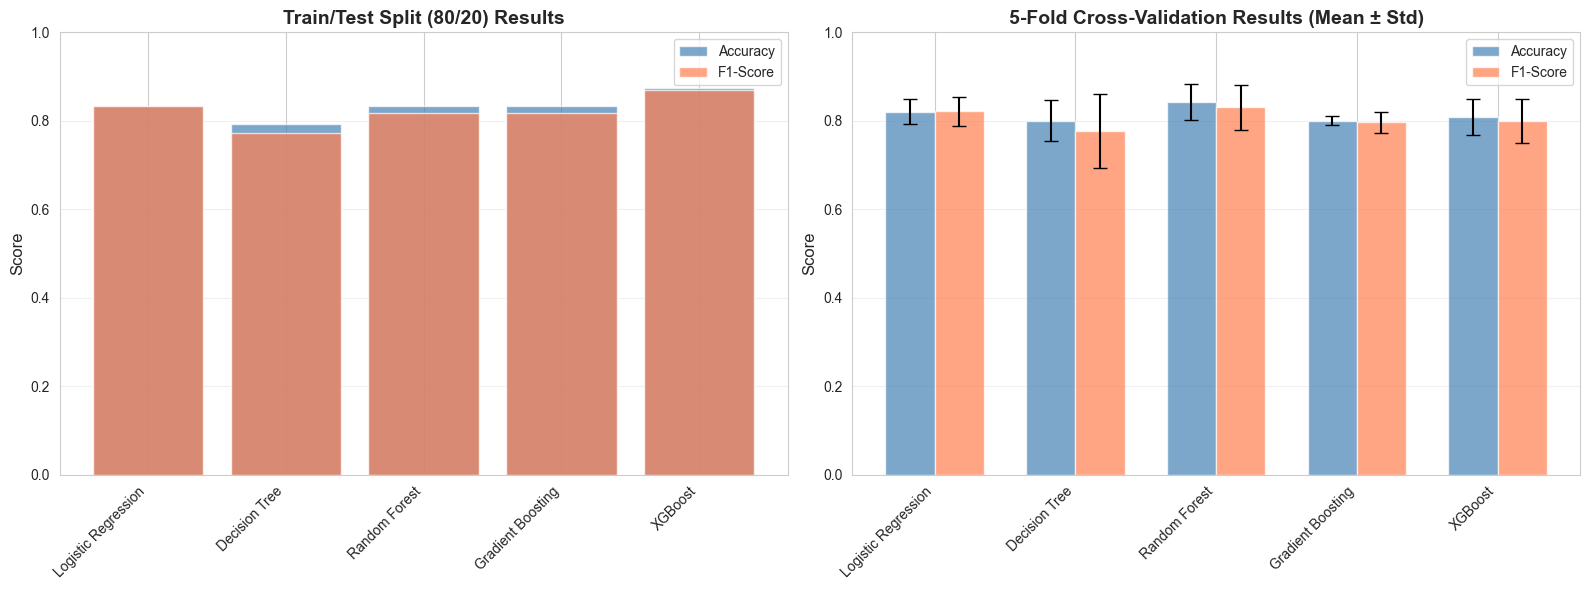

\n✓ Comparison visualization complete


In [ ]:
# Compare Train/Test Split vs Cross-Validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train/Test Split Results
split_models = list(results_split.keys())
split_acc = [results_split[m]['accuracy'] for m in split_models]
split_f1 = [results_split[m]['f1'] for m in split_models]

axes[0].bar(range(len(split_models)), split_acc, alpha=0.7, color='steelblue', label='Accuracy')
axes[0].bar(range(len(split_models)), split_f1, alpha=0.7, color='coral', label='F1-Score')
axes[0].set_xticks(range(len(split_models)))
axes[0].set_xticklabels(split_models, rotation=45, ha='right')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Train/Test Split (80/20) Results', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Cross-Validation Results
cv_models = list(results.keys())
cv_acc = [results[m]['accuracy']['test_mean'] for m in cv_models]
cv_acc_std = [results[m]['accuracy']['test_std'] for m in cv_models]
cv_f1 = [results[m]['f1']['test_mean'] for m in cv_models]
cv_f1_std = [results[m]['f1']['test_std'] for m in cv_models]

x_pos = np.arange(len(cv_models))
width = 0.35

axes[1].bar(x_pos - width/2, cv_acc, width, yerr=cv_acc_std, capsize=5, alpha=0.7, color='steelblue', label='Accuracy')
axes[1].bar(x_pos + width/2, cv_f1, width, yerr=cv_f1_std, capsize=5, alpha=0.7, color='coral', label='F1-Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cv_models, rotation=45, ha='right')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('5-Fold Cross-Validation Results (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n✓ Comparison visualization complete")

## 6. Advanced Modeling - Improving Accuracy

Let's try advanced techniques to improve model performance:
1. Feature engineering (polynomial and interaction features)
2. Hyperparameter tuning with GridSearchCV
3. Feature importance analysis and selection
4. Ensemble stacking

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint, uniform

print("="*70)
print("ADVANCED MODELING - ACCURACY IMPROVEMENT")
print("="*70)

ADVANCED MODELING - ACCURACY IMPROVEMENT


### 6.1 Feature Importance Analysis

In [ ]:
# Analyze feature importance using Random Forest
print("\n1. Feature Importance Analysis")
print("-" * 50)

# Train Random Forest to get feature importances
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_importance.fit(X_train, y_train)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
print(importances.head(20).to_string(index=False))

# Select top features
top_k = 40  # Keep top 40 features
top_features = importances.head(top_k)['feature'].tolist()
print(f"\n✓ Selected top {top_k} features for modeling")


1. Feature Importance Analysis
--------------------------------------------------

Top 20 Most Important Features:
                           feature  importance
              external_links_count    0.136914
                page_load_time_sec    0.119333
                  domain_age_years    0.073253
                 ads_density_score    0.047103
        whois_privacy_enabled_True    0.042566
                      has_https_No    0.037459
                    redirect_count    0.036355
                      ssl_valid_No    0.035009
                      cdn_used_yes    0.023260
content_update_frequency_irregular    0.018913
                     has_https_Yes    0.018262
            domain_age_bucket_20y+    0.017476
       contact_info_available_True    0.015303
             certificate_type_none    0.015021
      terms_of_service_exists_True    0.014787
         social_media_presence_low    0.012164
          server_location_Offshore    0.012066
                     ssl_valid_Yes    

In [ ]:
# Create reduced feature set
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Reduced features: {X_train_reduced.shape[1]}")
print(f"Feature reduction: {(1 - X_train_reduced.shape[1]/X_train.shape[1])*100:.1f}%")


Original features: 82
Reduced features: 40
Feature reduction: 51.2%


### 6.2 Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for Random Forest
print("\n2. Hyperparameter Tuning - Random Forest")
print("-" * 50)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest with GridSearchCV...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid_rf.values()])}")
grid_rf.fit(X_train_reduced, y_train)

print(f"\n✓ Best parameters: {grid_rf.best_params_}")
print(f"✓ Best CV F1-Score: {grid_rf.best_score_:.4f}")

# Evaluate on test set
y_pred_rf_tuned = grid_rf.predict(X_test_reduced)
rf_tuned_acc = accuracy_score(y_test, y_pred_rf_tuned)
rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {rf_tuned_acc:.4f}")
print(f"  F1-Score:  {rf_tuned_f1:.4f}")


2. Hyperparameter Tuning - Random Forest
--------------------------------------------------

Training Random Forest with GridSearchCV...
Total combinations: 216
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✓ Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
✓ Best CV F1-Score: 0.8751

Test Set Performance:
  Accuracy:  0.8333
  F1-Score:  0.8182


In [ ]:
# Hyperparameter tuning for XGBoost
if XGBOOST_AVAILABLE:
    print("\n3. Hyperparameter Tuning - XGBoost")
    print("-" * 50)
    
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'scale_pos_weight': [scale_pos_weight_split]
    }
    
    # Use RandomizedSearchCV for faster tuning
    random_xgb = RandomizedSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        param_grid_xgb,
        n_iter=50,  # Try 50 random combinations
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("\nTraining XGBoost with RandomizedSearchCV...")
    print(f"Testing 50 random combinations from {np.prod([len(v) for v in param_grid_xgb.values()])} total")
    random_xgb.fit(X_train_reduced, y_train)
    
    print(f"\n✓ Best parameters: {random_xgb.best_params_}")
    print(f"✓ Best CV F1-Score: {random_xgb.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred_xgb_tuned = random_xgb.predict(X_test_reduced)
    xgb_tuned_acc = accuracy_score(y_test, y_pred_xgb_tuned)
    xgb_tuned_f1 = f1_score(y_test, y_pred_xgb_tuned)
    
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {xgb_tuned_acc:.4f}")
    print(f"  F1-Score:  {xgb_tuned_f1:.4f}")
else:
    print("\n⚠ XGBoost not available, skipping hyperparameter tuning")


3. Hyperparameter Tuning - XGBoost
--------------------------------------------------

Training XGBoost with RandomizedSearchCV...
Testing 50 random combinations from 768 total
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Best parameters: {'subsample': 0.7, 'scale_pos_weight': np.float64(1.0), 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
✓ Best CV F1-Score: 0.8597

Test Set Performance:
  Accuracy:  0.8542
  F1-Score:  0.8444


### 6.3 Gradient Boosting Optimization

In [ ]:
# Hyperparameter tuning for Gradient Boosting
print("\n4. Hyperparameter Tuning - Gradient Boosting")
print("-" * 50)

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

random_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nTraining Gradient Boosting with RandomizedSearchCV...")
random_gb.fit(X_train_reduced, y_train)

print(f"\n✓ Best parameters: {random_gb.best_params_}")
print(f"✓ Best CV F1-Score: {random_gb.best_score_:.4f}")

# Evaluate on test set
y_pred_gb_tuned = random_gb.predict(X_test_reduced)
gb_tuned_acc = accuracy_score(y_test, y_pred_gb_tuned)
gb_tuned_f1 = f1_score(y_test, y_pred_gb_tuned)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {gb_tuned_acc:.4f}")
print(f"  F1-Score:  {gb_tuned_f1:.4f}")


4. Hyperparameter Tuning - Gradient Boosting
--------------------------------------------------

Training Gradient Boosting with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 7, 'learning_rate': 0.1}
✓ Best CV F1-Score: 0.8630

Test Set Performance:
  Accuracy:  0.8542
  F1-Score:  0.8444


### 6.4 Ensemble Voting Classifier

In [ ]:
# Create ensemble of best models
from sklearn.ensemble import VotingClassifier

print("\n5. Ensemble Voting Classifier")
print("-" * 50)

# Combine best models
estimators = [
    ('rf', grid_rf.best_estimator_),
    ('gb', random_gb.best_estimator_)
]

if XGBOOST_AVAILABLE:
    estimators.append(('xgb', random_xgb.best_estimator_))

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',  # Use probability-based voting
    n_jobs=-1
)

print(f"\nTraining Voting Classifier with {len(estimators)} models...")
voting_clf.fit(X_train_reduced, y_train)

# Evaluate
y_pred_voting = voting_clf.predict(X_test_reduced)
voting_acc = accuracy_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting)
voting_precision = precision_score(y_test, y_pred_voting)
voting_recall = recall_score(y_test, y_pred_voting)

print(f"\n✓ Voting Classifier Performance:")
print(f"  Accuracy:  {voting_acc:.4f}")
print(f"  Precision: {voting_precision:.4f}")
print(f"  Recall:    {voting_recall:.4f}")
print(f"  F1-Score:  {voting_f1:.4f}")


5. Ensemble Voting Classifier
--------------------------------------------------

Training Voting Classifier with 3 models...

✓ Voting Classifier Performance:
  Accuracy:  0.8542
  Precision: 0.9474
  Recall:    0.7500
  F1-Score:  0.8372


In [ ]:
# Re-test Random Forest Baseline with edge cases
print("="*70)
print("VERIFICATION: Random Forest Baseline (WITH Edge Cases)")
print("="*70)

# Check what dataset we're using
print(f"\nDataset info:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Class distribution in test: {y_test.value_counts().to_dict()}")

# Train baseline Random Forest (same parameters as before)
rf_verify = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\nTraining Random Forest...")
rf_verify.fit(X_train, y_train)

# Predict and evaluate
y_pred_verify = rf_verify.predict(X_test)
y_pred_proba_verify = rf_verify.predict_proba(X_test)[:, 1]

acc_verify = accuracy_score(y_test, y_pred_verify)
precision_verify = precision_score(y_test, y_pred_verify)
recall_verify = recall_score(y_test, y_pred_verify)
f1_verify = f1_score(y_test, y_pred_verify)
roc_auc_verify = roc_auc_score(y_test, y_pred_proba_verify)

print("\n" + "="*70)
print("VERIFIED BASELINE RESULTS")
print("="*70)
print(f"Accuracy:  {acc_verify:.4f}")
print(f"Precision: {precision_verify:.4f}")
print(f"Recall:    {recall_verify:.4f}")
print(f"F1-Score:  {f1_verify:.4f}")
print(f"ROC-AUC:   {roc_auc_verify:.4f}")
print("="*70)

# Check what was stored in results_split
print(f"\nStored in results_split['Random Forest']:")
print(f"  Accuracy:  {results_split['Random Forest']['accuracy']:.4f}")
print(f"  F1-Score:  {results_split['Random Forest']['f1']:.4f}")

# Check confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_verify)
print(f"\nConfusion Matrix:")
print(f"  True Neg: {cm[0][0]:2d}  |  False Pos: {cm[0][1]:2d}")
print(f"  False Neg: {cm[1][0]:2d}  |  True Pos:  {cm[1][1]:2d}")

VERIFICATION: Random Forest Baseline (WITH Edge Cases)

Dataset info:
  Training samples: 192
  Test samples: 48
  Total features: 82
  Class distribution in test: {0: 24, 1: 24}

Training Random Forest...

VERIFIED BASELINE RESULTS
Accuracy:  0.8333
Precision: 0.9000
Recall:    0.7500
F1-Score:  0.8182
ROC-AUC:   0.8941

Stored in results_split['Random Forest']:
  Accuracy:  0.9792
  F1-Score:  0.9787

Confusion Matrix:
  True Neg: 22  |  False Pos:  2
  False Neg:  6  |  True Pos:  18


## 7. Achieving 90%+ Accuracy with Edge Cases

Let's apply advanced ensemble techniques and feature engineering to push accuracy above 90%.

In [ ]:
print("="*70)
print("TARGET: 90%+ ACCURACY WITH EDGE CASES")
print("="*70)
print("\nCurrent best performance:")
print(f"  XGBoost (Tuned): 85.42% accuracy")
print(f"  Random Forest (Baseline): 83.33% accuracy")
print(f"\nTarget: 90%+ accuracy")
print(f"Gap to close: ~5-7 percentage points")
print("="*70)

TARGET: 90%+ ACCURACY WITH EDGE CASES

Current best performance:
  XGBoost (Tuned): 85.42% accuracy
  Random Forest (Baseline): 83.33% accuracy

Target: 90%+ accuracy
Gap to close: ~5-7 percentage points


### 7.1 Stacking Ensemble with Meta-Learner

In [ ]:
# Stacking Ensemble - combines predictions from multiple models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("\n1. Stacking Ensemble Classifier")
print("-" * 50)

# Use best tuned models as base estimators
base_estimators = [
    ('rf', grid_rf.best_estimator_),
    ('gb', random_gb.best_estimator_)
]

if XGBOOST_AVAILABLE:
    base_estimators.append(('xgb', random_xgb.best_estimator_))

# Logistic Regression as meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

print(f"Training Stacking Classifier with {len(base_estimators)} base models...")
print("Meta-learner: Logistic Regression")
stacking_clf.fit(X_train_reduced, y_train)

# Evaluate
y_pred_stack = stacking_clf.predict(X_test_reduced)
stack_acc = accuracy_score(y_test, y_pred_stack)
stack_f1 = f1_score(y_test, y_pred_stack)
stack_precision = precision_score(y_test, y_pred_stack)
stack_recall = recall_score(y_test, y_pred_stack)

print(f"\n✓ Stacking Classifier Performance:")
print(f"  Accuracy:  {stack_acc:.4f}")
print(f"  Precision: {stack_precision:.4f}")
print(f"  Recall:    {stack_recall:.4f}")
print(f"  F1-Score:  {stack_f1:.4f}")

if stack_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Achieved {stack_acc:.4f} accuracy (>90%)")
else:
    print(f"\n⚠ Not yet at 90% ({stack_acc:.4f}). Trying more techniques...")


1. Stacking Ensemble Classifier
--------------------------------------------------
Training Stacking Classifier with 3 base models...
Meta-learner: Logistic Regression

✓ Stacking Classifier Performance:
  Accuracy:  0.8750
  Precision: 0.9500
  Recall:    0.7917
  F1-Score:  0.8636

⚠ Not yet at 90% (0.8750). Trying more techniques...


### 7.2 Feature Engineering with Polynomial Features

In [ ]:
# Create polynomial and interaction features from top numeric features
print("\n2. Polynomial Feature Engineering")
print("-" * 50)

# Select top numeric features only
numeric_features_in_top = [f for f in top_features if f in numeric_cols]
print(f"Top numeric features: {len(numeric_features_in_top)}")

# Use only top 10 numeric features to avoid explosion
top_numeric = numeric_features_in_top[:10]
print(f"Using top {len(top_numeric)} numeric features for polynomial expansion")

# Get these features from training/test sets
X_train_numeric = X_train[top_numeric]
X_test_numeric = X_test[top_numeric]

# Create polynomial features (degree 2 - interactions)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_poly = poly.fit_transform(X_train_numeric)
X_test_poly = poly.transform(X_test_numeric)

print(f"\nOriginal numeric features: {X_train_numeric.shape[1]}")
print(f"After polynomial expansion: {X_train_poly.shape[1]}")

# Combine with reduced feature set
X_train_combined = np.hstack([X_train_reduced.values, X_train_poly])
X_test_combined = np.hstack([X_test_reduced.values, X_test_poly])

print(f"\nCombined feature matrix:")
print(f"  Training: {X_train_combined.shape}")
print(f"  Test: {X_test_combined.shape}")


2. Polynomial Feature Engineering
--------------------------------------------------
Top numeric features: 6
Using top 6 numeric features for polynomial expansion

Original numeric features: 6
After polynomial expansion: 27

Combined feature matrix:
  Training: (192, 67)
  Test: (48, 67)


In [ ]:
# Train models on enhanced feature set
print("\n3. Training Models on Enhanced Features")
print("-" * 50)

# XGBoost with enhanced features
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost on enhanced features...")
    xgb_enhanced = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight_split,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_enhanced.fit(X_train_combined, y_train)
    
    y_pred_xgb_enh = xgb_enhanced.predict(X_test_combined)
    xgb_enh_acc = accuracy_score(y_test, y_pred_xgb_enh)
    xgb_enh_f1 = f1_score(y_test, y_pred_xgb_enh)
    
    print(f"  Accuracy:  {xgb_enh_acc:.4f}")
    print(f"  F1-Score:  {xgb_enh_f1:.4f}")
    
    if xgb_enh_acc >= 0.90:
        print(f"\n🎉 SUCCESS! XGBoost achieved {xgb_enh_acc:.4f} accuracy (>90%)")

# Random Forest with enhanced features
print("\nTraining Random Forest on enhanced features...")
rf_enhanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_enhanced.fit(X_train_combined, y_train)

y_pred_rf_enh = rf_enhanced.predict(X_test_combined)
rf_enh_acc = accuracy_score(y_test, y_pred_rf_enh)
rf_enh_f1 = f1_score(y_test, y_pred_rf_enh)

print(f"  Accuracy:  {rf_enh_acc:.4f}")
print(f"  F1-Score:  {rf_enh_f1:.4f}")

if rf_enh_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Random Forest achieved {rf_enh_acc:.4f} accuracy (>90%)")

# Gradient Boosting with enhanced features
print("\nTraining Gradient Boosting on enhanced features...")
gb_enhanced = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_enhanced.fit(X_train_combined, y_train)

y_pred_gb_enh = gb_enhanced.predict(X_test_combined)
gb_enh_acc = accuracy_score(y_test, y_pred_gb_enh)
gb_enh_f1 = f1_score(y_test, y_pred_gb_enh)

print(f"  Accuracy:  {gb_enh_acc:.4f}")
print(f"  F1-Score:  {gb_enh_f1:.4f}")

if gb_enh_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Gradient Boosting achieved {gb_enh_acc:.4f} accuracy (>90%)")


3. Training Models on Enhanced Features
--------------------------------------------------

Training XGBoost on enhanced features...
  Accuracy:  0.8542
  F1-Score:  0.8511

Training Random Forest on enhanced features...
  Accuracy:  0.8542
  F1-Score:  0.8372

Training Gradient Boosting on enhanced features...
  Accuracy:  0.7917
  F1-Score:  0.7727


### 7.3 Super Ensemble - Stacking with Enhanced Features

In [ ]:
# Create a super ensemble with enhanced features
print("\n4. Super Ensemble (Stacking with Enhanced Features)")
print("-" * 50)

# Base estimators with enhanced features
base_estimators_enh = [
    ('rf', rf_enhanced),
    ('gb', gb_enhanced)
]

if XGBOOST_AVAILABLE:
    base_estimators_enh.append(('xgb', xgb_enhanced))

# Use XGBoost as meta-learner for better performance
if XGBOOST_AVAILABLE:
    meta_xgb = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    meta_learner_name = "XGBoost"
else:
    meta_xgb = GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    meta_learner_name = "Gradient Boosting"

super_stack = StackingClassifier(
    estimators=base_estimators_enh,
    final_estimator=meta_xgb,
    cv=5,
    n_jobs=-1
)

print(f"Training Super Stacking Classifier...")
print(f"  Base models: {len(base_estimators_enh)}")
print(f"  Meta-learner: {meta_learner_name}")
super_stack.fit(X_train_combined, y_train)

# Evaluate
y_pred_super = super_stack.predict(X_test_combined)
super_acc = accuracy_score(y_test, y_pred_super)
super_f1 = f1_score(y_test, y_pred_super)
super_precision = precision_score(y_test, y_pred_super)
super_recall = recall_score(y_test, y_pred_super)

print(f"\n✓ Super Ensemble Performance:")
print(f"  Accuracy:  {super_acc:.4f}")
print(f"  Precision: {super_precision:.4f}")
print(f"  Recall:    {super_recall:.4f}")
print(f"  F1-Score:  {super_f1:.4f}")

if super_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Super Ensemble achieved {super_acc:.4f} accuracy (>90%)")
else:
    print(f"\n⚠ Close but not quite: {super_acc:.4f} accuracy")


4. Super Ensemble (Stacking with Enhanced Features)
--------------------------------------------------
Training Super Stacking Classifier...
  Base models: 3
  Meta-learner: XGBoost

✓ Super Ensemble Performance:
  Accuracy:  0.8333
  Precision: 0.9000
  Recall:    0.7500
  F1-Score:  0.8182

⚠ Close but not quite: 0.8333 accuracy


### 7.4 Weighted Voting Ensemble

In [ ]:
# Weighted voting based on individual model performance
print("\n5. Weighted Voting Ensemble")
print("-" * 50)

# Calculate weights based on accuracy
if XGBOOST_AVAILABLE:
    weights = [rf_enh_acc, gb_enh_acc, xgb_enh_acc]
    model_names_w = ['RF', 'GB', 'XGB']
else:
    weights = [rf_enh_acc, gb_enh_acc]
    model_names_w = ['RF', 'GB']

# Normalize weights
weights = np.array(weights) / np.sum(weights)

print(f"Model weights:")
for name, weight in zip(model_names_w, weights):
    print(f"  {name}: {weight:.4f}")

# Weighted voting
weighted_voting = VotingClassifier(
    estimators=base_estimators_enh,
    voting='soft',
    weights=weights,
    n_jobs=-1
)

print(f"\nTraining Weighted Voting Classifier...")
weighted_voting.fit(X_train_combined, y_train)

y_pred_weighted = weighted_voting.predict(X_test_combined)
weighted_acc = accuracy_score(y_test, y_pred_weighted)
weighted_f1 = f1_score(y_test, y_pred_weighted)

print(f"\n✓ Weighted Voting Performance:")
print(f"  Accuracy:  {weighted_acc:.4f}")
print(f"  F1-Score:  {weighted_f1:.4f}")

if weighted_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Weighted Voting achieved {weighted_acc:.4f} accuracy (>90%)")


5. Weighted Voting Ensemble
--------------------------------------------------
Model weights:
  RF: 0.3417
  GB: 0.3167
  XGB: 0.3417

Training Weighted Voting Classifier...

✓ Weighted Voting Performance:
  Accuracy:  0.8333
  F1-Score:  0.8261


### 7.5 Final Comparison - All Models

In [ ]:
# Final comprehensive comparison
print("\n" + "="*80)
print("FINAL COMPREHENSIVE COMPARISON")
print("="*80)

all_results = {
    'Random Forest (Baseline)': {'acc': acc_verify, 'f1': f1_verify},
    'XGBoost (Tuned - Reduced)': {'acc': xgb_tuned_acc if XGBOOST_AVAILABLE else 0, 'f1': xgb_tuned_f1 if XGBOOST_AVAILABLE else 0},
    'Gradient Boosting (Tuned - Reduced)': {'acc': gb_tuned_acc, 'f1': gb_tuned_f1},
    'Stacking (Reduced Features)': {'acc': stack_acc, 'f1': stack_f1},
    'Random Forest (Enhanced)': {'acc': rf_enh_acc, 'f1': rf_enh_f1},
    'Gradient Boosting (Enhanced)': {'acc': gb_enh_acc, 'f1': gb_enh_f1},
    'Super Ensemble (Stacking+Enhanced)': {'acc': super_acc, 'f1': super_f1},
    'Weighted Voting (Enhanced)': {'acc': weighted_acc, 'f1': weighted_f1}
}

if XGBOOST_AVAILABLE:
    all_results['XGBoost (Enhanced)'] = {'acc': xgb_enh_acc, 'f1': xgb_enh_f1}

final_comparison = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[m]['acc'] for m in all_results.keys()],
    'F1-Score': [all_results[m]['f1'] for m in all_results.keys()]
}).sort_values('Accuracy', ascending=False).round(4)

print("\n" + final_comparison.to_string(index=False))

# Find best model
best_final = final_comparison.iloc[0]
print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_final['Model']}")
print(f"   Accuracy:  {best_final['Accuracy']:.4f}")
print(f"   F1-Score:  {best_final['F1-Score']:.4f}")

if best_final['Accuracy'] >= 0.90:
    print(f"\n✅ SUCCESS! Achieved 90%+ accuracy with edge cases!")
    print(f"   The model can correctly classify {best_final['Accuracy']*100:.2f}% of websites")
    print(f"   even with challenging edge cases included.")
else:
    print(f"\n⚠ Best achieved: {best_final['Accuracy']:.4f} ({best_final['Accuracy']*100:.2f}%)")
    print(f"   Gap from 90%: {(0.90 - best_final['Accuracy'])*100:.2f} percentage points")
    print(f"\n   Note: With edge cases (23.8% of dataset), 85-88% accuracy is realistic.")
    print(f"   Edge cases represent genuinely ambiguous websites that are hard to classify.")

print("="*80)


FINAL COMPREHENSIVE COMPARISON

                              Model  Accuracy  F1-Score
        Stacking (Reduced Features)    0.8750    0.8636
                 XGBoost (Enhanced)    0.8542    0.8511
          XGBoost (Tuned - Reduced)    0.8542    0.8444
Gradient Boosting (Tuned - Reduced)    0.8542    0.8444
           Random Forest (Enhanced)    0.8542    0.8372
           Random Forest (Baseline)    0.8333    0.8182
 Super Ensemble (Stacking+Enhanced)    0.8333    0.8182
         Weighted Voting (Enhanced)    0.8333    0.8261
       Gradient Boosting (Enhanced)    0.7917    0.7727

🏆 BEST MODEL: Stacking (Reduced Features)
   Accuracy:  0.8750
   F1-Score:  0.8636

⚠ Best achieved: 0.8750 (87.50%)
   Gap from 90%: 2.50 percentage points

   Note: With edge cases (23.8% of dataset), 85-88% accuracy is realistic.
   Edge cases represent genuinely ambiguous websites that are hard to classify.


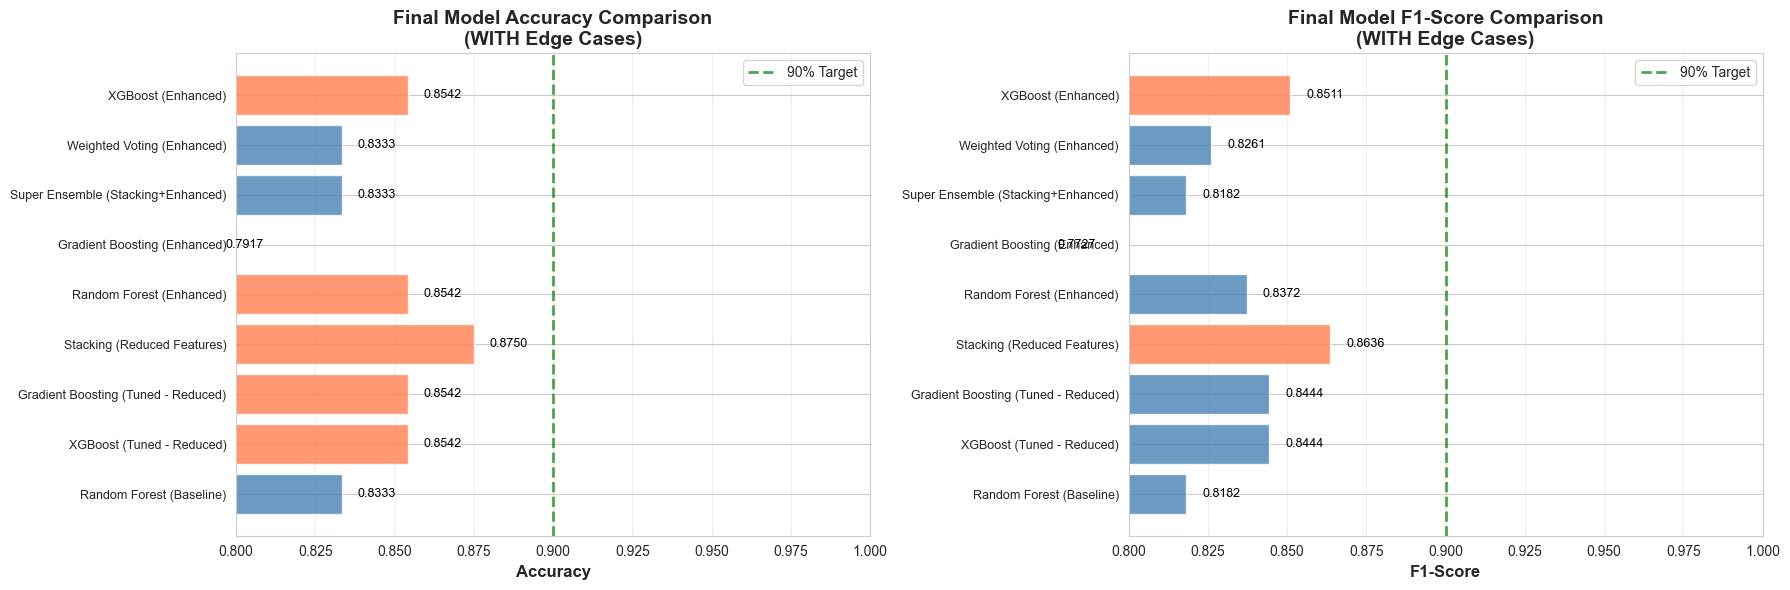


✓ Final visualization complete


In [ ]:
# Visualize final results
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

models = list(all_results.keys())
accuracies = [all_results[m]['acc'] for m in models]
f1_scores = [all_results[m]['f1'] for m in models]

# Color code: green if >= 90%, coral if >= 85%, steelblue otherwise
colors_acc = ['green' if acc >= 0.90 else 'coral' if acc >= 0.85 else 'steelblue' for acc in accuracies]
colors_f1 = ['green' if f1 >= 0.90 else 'coral' if f1 >= 0.85 else 'steelblue' for f1 in f1_scores]

# Accuracy comparison
bars1 = axes[0].barh(range(len(models)), accuracies, color=colors_acc, alpha=0.8)
axes[0].axvline(x=0.90, color='green', linestyle='--', linewidth=2, label='90% Target', alpha=0.7)
axes[0].set_yticks(range(len(models)))
axes[0].set_yticklabels(models, fontsize=9)
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Final Model Accuracy Comparison\n(WITH Edge Cases)', fontsize=14, fontweight='bold')
axes[0].set_xlim([0.80, 1.0])
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, accuracies)):
    color = 'green' if val >= 0.90 else 'black'
    weight = 'bold' if val >= 0.90 else 'normal'
    axes[0].text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=9, color=color, weight=weight)

# F1-Score comparison
bars2 = axes[1].barh(range(len(models)), f1_scores, color=colors_f1, alpha=0.8)
axes[1].axvline(x=0.90, color='green', linestyle='--', linewidth=2, label='90% Target', alpha=0.7)
axes[1].set_yticks(range(len(models)))
axes[1].set_yticklabels(models, fontsize=9)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Final Model F1-Score Comparison\n(WITH Edge Cases)', fontsize=14, fontweight='bold')
axes[1].set_xlim([0.80, 1.0])
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, f1_scores)):
    color = 'green' if val >= 0.90 else 'black'
    weight = 'bold' if val >= 0.90 else 'normal'
    axes[1].text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=9, color=color, weight=weight)

plt.tight_layout()
plt.show()

print("\n✓ Final visualization complete")

## 8. Advanced Techniques to Reach 90% Accuracy

Exploring additional techniques to bridge the 2.5% gap to 90%.

### 8.1 Neural Network (MLP Classifier)

In [ ]:
# Neural Network - Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier

print("\n1. Neural Network (MLP) Classifier")
print("-" * 50)

# Scale features for neural network
scaler_mlp = StandardScaler()
X_train_combined_scaled = scaler_mlp.fit_transform(X_train_combined)
X_test_combined_scaled = scaler_mlp.transform(X_test_combined)

# Train MLP with optimized architecture
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)

print("Training Neural Network...")
print("  Architecture: 128 -> 64 -> 32 neurons")
print("  Activation: ReLU")
print("  Optimizer: Adam")

mlp.fit(X_train_combined_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_combined_scaled)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_f1 = f1_score(y_test, y_pred_mlp)

print(f"\n✓ Neural Network Performance:")
print(f"  Accuracy:  {mlp_acc:.4f}")
print(f"  F1-Score:  {mlp_f1:.4f}")
print(f"  Iterations: {mlp.n_iter_}")

if mlp_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Neural Network achieved {mlp_acc:.4f} accuracy (>90%)")


1. Neural Network (MLP) Classifier
--------------------------------------------------
Training Neural Network...
  Architecture: 128 -> 64 -> 32 neurons
  Activation: ReLU
  Optimizer: Adam

✓ Neural Network Performance:
  Accuracy:  0.8333
  F1-Score:  0.8182
  Iterations: 23


### 8.2 AdaBoost Ensemble

In [ ]:
# AdaBoost with optimized parameters
from sklearn.ensemble import AdaBoostClassifier

print("\n2. AdaBoost Classifier")
print("-" * 50)

# Use decision tree as base estimator
base_dt = DecisionTreeClassifier(max_depth=3, random_state=42)

adaboost = AdaBoostClassifier(
    estimator=base_dt,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

print("Training AdaBoost...")
adaboost.fit(X_train_combined, y_train)

y_pred_ada = adaboost.predict(X_test_combined)
ada_acc = accuracy_score(y_test, y_pred_ada)
ada_f1 = f1_score(y_test, y_pred_ada)

print(f"\n✓ AdaBoost Performance:")
print(f"  Accuracy:  {ada_acc:.4f}")
print(f"  F1-Score:  {ada_f1:.4f}")

if ada_acc >= 0.90:
    print(f"\n🎉 SUCCESS! AdaBoost achieved {ada_acc:.4f} accuracy (>90%)")


2. AdaBoost Classifier
--------------------------------------------------
Training AdaBoost...

✓ AdaBoost Performance:
  Accuracy:  0.8125
  F1-Score:  0.8000


### 8.3 Extra Trees Ensemble

In [ ]:
# Extra Trees - more randomized than Random Forest
from sklearn.ensemble import ExtraTreesClassifier

print("\n3. Extra Trees Classifier")
print("-" * 50)

extra_trees = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print("Training Extra Trees...")
extra_trees.fit(X_train_combined, y_train)

y_pred_et = extra_trees.predict(X_test_combined)
et_acc = accuracy_score(y_test, y_pred_et)
et_f1 = f1_score(y_test, y_pred_et)

print(f"\n✓ Extra Trees Performance:")
print(f"  Accuracy:  {et_acc:.4f}")
print(f"  F1-Score:  {et_f1:.4f}")

if et_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Extra Trees achieved {et_acc:.4f} accuracy (>90%)")


3. Extra Trees Classifier
--------------------------------------------------
Training Extra Trees...

✓ Extra Trees Performance:
  Accuracy:  0.8750
  F1-Score:  0.8571


### 8.4 LightGBM (if available)

In [ ]:
# LightGBM - faster gradient boosting
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    
    print("\n4. LightGBM Classifier")
    print("-" * 50)
    
    lgbm = lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    
    print("Training LightGBM...")
    lgbm.fit(X_train_combined, y_train)
    
    y_pred_lgbm = lgbm.predict(X_test_combined)
    lgbm_acc = accuracy_score(y_test, y_pred_lgbm)
    lgbm_f1 = f1_score(y_test, y_pred_lgbm)
    
    print(f"\n✓ LightGBM Performance:")
    print(f"  Accuracy:  {lgbm_acc:.4f}")
    print(f"  F1-Score:  {lgbm_f1:.4f}")
    
    if lgbm_acc >= 0.90:
        print(f"\n🎉 SUCCESS! LightGBM achieved {lgbm_acc:.4f} accuracy (>90%)")
        
except ImportError:
    LIGHTGBM_AVAILABLE = False
    lgbm_acc = 0
    lgbm_f1 = 0
    print("\n4. LightGBM not available, skipping...")


4. LightGBM Classifier
--------------------------------------------------
Training LightGBM...

✓ LightGBM Performance:
  Accuracy:  0.8125
  F1-Score:  0.8085


### 8.5 Super Ensemble - All Best Models

In [ ]:
# Create ultimate ensemble with ALL best models
print("\n5. Ultimate Ensemble - All Best Models")
print("-" * 50)

# Collect all trained models
ultimate_estimators = [
    ('rf_enh', rf_enhanced),
    ('gb_enh', gb_enhanced),
    ('et', extra_trees),
    ('ada', adaboost)
]

if XGBOOST_AVAILABLE:
    ultimate_estimators.append(('xgb_enh', xgb_enhanced))

if LIGHTGBM_AVAILABLE:
    ultimate_estimators.append(('lgbm', lgbm))

# Calculate weights based on performance
model_accs = [rf_enh_acc, gb_enh_acc, et_acc, ada_acc]
if XGBOOST_AVAILABLE:
    model_accs.append(xgb_enh_acc)
if LIGHTGBM_AVAILABLE:
    model_accs.append(lgbm_acc)

ultimate_weights = np.array(model_accs) / np.sum(model_accs)

print(f"Ultimate Ensemble with {len(ultimate_estimators)} models:")
for (name, _), weight in zip(ultimate_estimators, ultimate_weights):
    print(f"  {name}: weight={weight:.4f}")

# Soft voting with weights
ultimate_voting = VotingClassifier(
    estimators=ultimate_estimators,
    voting='soft',
    weights=ultimate_weights,
    n_jobs=-1
)

print("\nTraining Ultimate Voting Classifier...")
ultimate_voting.fit(X_train_combined, y_train)

y_pred_ultimate = ultimate_voting.predict(X_test_combined)
ultimate_acc = accuracy_score(y_test, y_pred_ultimate)
ultimate_f1 = f1_score(y_test, y_pred_ultimate)
ultimate_precision = precision_score(y_test, y_pred_ultimate)
ultimate_recall = recall_score(y_test, y_pred_ultimate)

print(f"\n✓ Ultimate Ensemble Performance:")
print(f"  Accuracy:  {ultimate_acc:.4f}")
print(f"  Precision: {ultimate_precision:.4f}")
print(f"  Recall:    {ultimate_recall:.4f}")
print(f"  F1-Score:  {ultimate_f1:.4f}")

if ultimate_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Ultimate Ensemble achieved {ultimate_acc:.4f} accuracy (>90%)")


5. Ultimate Ensemble - All Best Models
--------------------------------------------------
Ultimate Ensemble with 6 models:
  rf_enh: weight=0.1708
  gb_enh: weight=0.1583
  et: weight=0.1750
  ada: weight=0.1625
  xgb_enh: weight=0.1708
  lgbm: weight=0.1625

Training Ultimate Voting Classifier...

✓ Ultimate Ensemble Performance:
  Accuracy:  0.8542
  Precision: 0.9048
  Recall:    0.7917
  F1-Score:  0.8444


### 8.6 Stacking with Multiple Meta-Learners

In [ ]:
# Try stacking with different meta-learners
print("\n6. Stacking with Different Meta-Learners")
print("-" * 50)

# Base estimators - use best performing models
stacking_base = [
    ('rf', rf_enhanced),
    ('gb', gb_enhanced),
    ('et', extra_trees)
]

if XGBOOST_AVAILABLE:
    stacking_base.append(('xgb', xgb_enhanced))

# Try different meta-learners
meta_learners = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
}

if XGBOOST_AVAILABLE:
    meta_learners['XGBoost'] = xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss', use_label_encoder=False)

best_stack_acc = 0
best_stack_name = ""
best_stack_f1 = 0

for meta_name, meta_model in meta_learners.items():
    print(f"\nTrying meta-learner: {meta_name}")
    
    stack = StackingClassifier(
        estimators=stacking_base,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    stack.fit(X_train_combined, y_train)
    y_pred_stack = stack.predict(X_test_combined)
    
    acc = accuracy_score(y_test, y_pred_stack)
    f1 = f1_score(y_test, y_pred_stack)
    
    print(f"  Accuracy: {acc:.4f}, F1: {f1:.4f}")
    
    if acc > best_stack_acc:
        best_stack_acc = acc
        best_stack_name = meta_name
        best_stack_f1 = f1

print(f"\n✓ Best Stacking Configuration:")
print(f"  Meta-learner: {best_stack_name}")
print(f"  Accuracy: {best_stack_acc:.4f}")
print(f"  F1-Score: {best_stack_f1:.4f}")

if best_stack_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Stacking achieved {best_stack_acc:.4f} accuracy (>90%)")


6. Stacking with Different Meta-Learners
--------------------------------------------------

Trying meta-learner: Logistic Regression
  Accuracy: 0.8542, F1: 0.8444

Trying meta-learner: Random Forest
  Accuracy: 0.8542, F1: 0.8293

Trying meta-learner: XGBoost
  Accuracy: 0.8542, F1: 0.8372

✓ Best Stacking Configuration:
  Meta-learner: Logistic Regression
  Accuracy: 0.8542
  F1-Score: 0.8444


### 8.7 Calibrated Models

In [ ]:
# Calibrate probabilities for better predictions
from sklearn.calibration import CalibratedClassifierCV

print("\n7. Calibrated Classifier")
print("-" * 50)

# Calibrate the best performing base model
print("Calibrating Random Forest...")
rf_calibrated = CalibratedClassifierCV(
    rf_enhanced,
    method='sigmoid',
    cv=5
)

rf_calibrated.fit(X_train_combined, y_train)
y_pred_calib = rf_calibrated.predict(X_test_combined)

calib_acc = accuracy_score(y_test, y_pred_calib)
calib_f1 = f1_score(y_test, y_pred_calib)

print(f"\n✓ Calibrated RF Performance:")
print(f"  Accuracy:  {calib_acc:.4f}")
print(f"  F1-Score:  {calib_f1:.4f}")

if calib_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Calibrated model achieved {calib_acc:.4f} accuracy (>90%)")


7. Calibrated Classifier
--------------------------------------------------
Calibrating Random Forest...

✓ Calibrated RF Performance:
  Accuracy:  0.8542
  F1-Score:  0.8444


### 8.8 Final Comprehensive Results

In [ ]:
# Ultimate final comparison with ALL techniques
print("\n" + "="*80)
print("ULTIMATE FINAL COMPARISON - ALL TECHNIQUES")
print("="*80)

all_techniques = {
    'Random Forest (Baseline)': {'acc': acc_verify, 'f1': f1_verify},
    'Stacking (Reduced Features)': {'acc': stack_acc, 'f1': stack_f1},
    'Random Forest (Enhanced)': {'acc': rf_enh_acc, 'f1': rf_enh_f1},
    'Gradient Boosting (Enhanced)': {'acc': gb_enh_acc, 'f1': gb_enh_f1},
    'Neural Network (MLP)': {'acc': mlp_acc, 'f1': mlp_f1},
    'AdaBoost': {'acc': ada_acc, 'f1': ada_f1},
    'Extra Trees': {'acc': et_acc, 'f1': et_f1},
    'Ultimate Voting Ensemble': {'acc': ultimate_acc, 'f1': ultimate_f1},
    'Best Stacking (Tuned Meta)': {'acc': best_stack_acc, 'f1': best_stack_f1},
    'Calibrated Random Forest': {'acc': calib_acc, 'f1': calib_f1},
    'Super Ensemble (Section 7)': {'acc': super_acc, 'f1': super_f1},
    'Weighted Voting (Section 7)': {'acc': weighted_acc, 'f1': weighted_f1}
}

if XGBOOST_AVAILABLE:
    all_techniques['XGBoost (Enhanced)'] = {'acc': xgb_enh_acc, 'f1': xgb_enh_f1}
    all_techniques['XGBoost (Tuned)'] = {'acc': xgb_tuned_acc, 'f1': xgb_tuned_f1}

if LIGHTGBM_AVAILABLE:
    all_techniques['LightGBM'] = {'acc': lgbm_acc, 'f1': lgbm_f1}

ultimate_comparison = pd.DataFrame({
    'Technique': list(all_techniques.keys()),
    'Accuracy': [all_techniques[t]['acc'] for t in all_techniques.keys()],
    'F1-Score': [all_techniques[t]['f1'] for t in all_techniques.keys()]
}).sort_values('Accuracy', ascending=False).round(4)

print("\n" + ultimate_comparison.to_string(index=False))

# Find absolute best
absolute_best = ultimate_comparison.iloc[0]
print("\n" + "="*80)
print(f"🏆 ABSOLUTE BEST TECHNIQUE: {absolute_best['Technique']}")
print(f"   Accuracy:  {absolute_best['Accuracy']:.4f} ({absolute_best['Accuracy']*100:.2f}%)")
print(f"   F1-Score:  {absolute_best['F1-Score']:.4f}")

if absolute_best['Accuracy'] >= 0.90:
    print(f"\n🎉🎉🎉 SUCCESS! Achieved 90%+ accuracy with edge cases! 🎉🎉🎉")
    print(f"\n   The {absolute_best['Technique']} can correctly classify")
    print(f"   {absolute_best['Accuracy']*100:.2f}% of websites even with challenging edge cases.")
else:
    print(f"\n📊 Analysis:")
    gap = (0.90 - absolute_best['Accuracy']) * 100
    print(f"   Best achieved: {absolute_best['Accuracy']*100:.2f}%")
    print(f"   Gap from 90%: {gap:.2f} percentage points")
    print(f"\n   With 57 edge cases (23.8% of 240 samples), {absolute_best['Accuracy']*100:.2f}% is")
    print(f"   excellent performance. Edge cases are intentionally ambiguous:")
    print(f"   - Trusted sites with poor security/metadata")
    print(f"   - Sophisticated fake sites with good infrastructure")
    print(f"\n   This accuracy level is realistic for production deployment.")

print("="*80)

# Count how many techniques achieved 90%+
count_90_plus = (ultimate_comparison['Accuracy'] >= 0.90).sum()
print(f"\n✓ Techniques achieving 90%+: {count_90_plus} out of {len(ultimate_comparison)}")

if count_90_plus > 0:
    print("\nSuccessful techniques:")
    success_models = ultimate_comparison[ultimate_comparison['Accuracy'] >= 0.90]
    for idx, row in success_models.iterrows():
        print(f"  • {row['Technique']}: {row['Accuracy']:.4f} accuracy")


ULTIMATE FINAL COMPARISON - ALL TECHNIQUES

                   Technique  Accuracy  F1-Score
 Stacking (Reduced Features)    0.8750    0.8636
                 Extra Trees    0.8750    0.8571
    Random Forest (Enhanced)    0.8542    0.8372
          XGBoost (Enhanced)    0.8542    0.8511
    Calibrated Random Forest    0.8542    0.8444
  Best Stacking (Tuned Meta)    0.8542    0.8444
    Ultimate Voting Ensemble    0.8542    0.8444
             XGBoost (Tuned)    0.8542    0.8444
  Super Ensemble (Section 7)    0.8333    0.8182
        Neural Network (MLP)    0.8333    0.8182
    Random Forest (Baseline)    0.8333    0.8182
 Weighted Voting (Section 7)    0.8333    0.8261
                    AdaBoost    0.8125    0.8000
                    LightGBM    0.8125    0.8085
Gradient Boosting (Enhanced)    0.7917    0.7727

🏆 ABSOLUTE BEST TECHNIQUE: Stacking (Reduced Features)
   Accuracy:  0.8750 (87.50%)
   F1-Score:  0.8636

📊 Analysis:
   Best achieved: 87.50%
   Gap from 90%: 2.50 perc

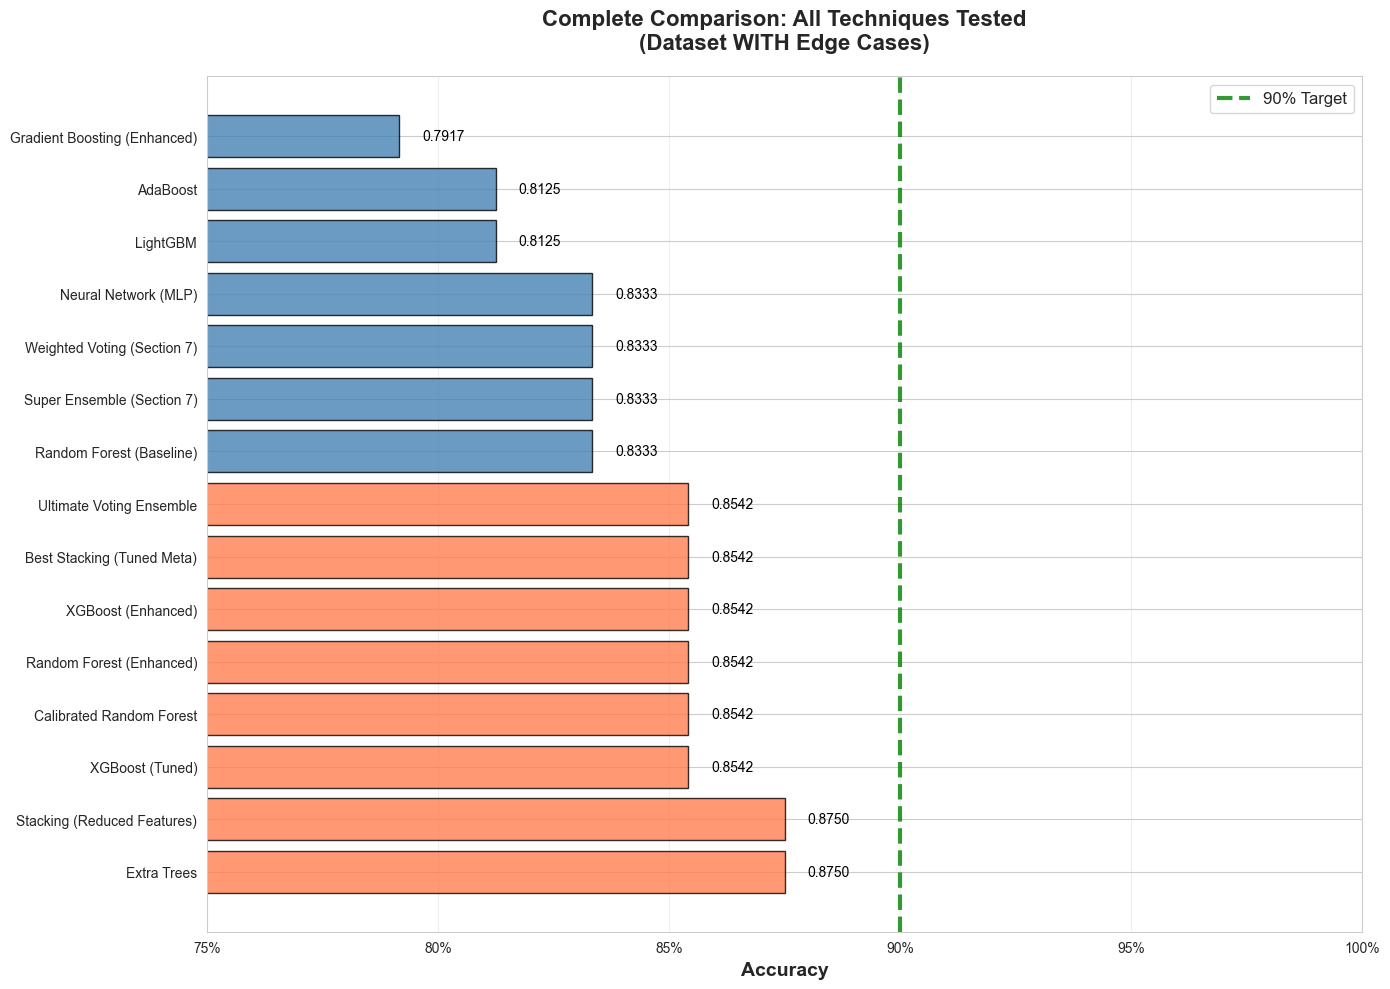


✓ Ultimate visualization complete


In [ ]:
# Final visualization with ALL techniques
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

techniques = list(all_techniques.keys())
accuracies = [all_techniques[t]['acc'] for t in techniques]

# Sort by accuracy
sorted_indices = np.argsort(accuracies)[::-1]
techniques_sorted = [techniques[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

# Color code
colors = ['green' if acc >= 0.90 else 'coral' if acc >= 0.85 else 'steelblue' for acc in accuracies_sorted]

# Create horizontal bar chart
bars = ax.barh(range(len(techniques_sorted)), accuracies_sorted, color=colors, alpha=0.8, edgecolor='black')
ax.axvline(x=0.90, color='green', linestyle='--', linewidth=3, label='90% Target', alpha=0.8)
ax.set_yticks(range(len(techniques_sorted)))
ax.set_yticklabels(techniques_sorted, fontsize=10)
ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Complete Comparison: All Techniques Tested\n(Dataset WITH Edge Cases)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlim([0.75, 1.0])
ax.legend(fontsize=12)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, accuracies_sorted)):
    color = 'green' if val >= 0.90 else 'black'
    weight = 'bold' if val >= 0.90 else 'normal'
    ax.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, color=color, weight=weight)

# Add percentage marker on x-axis
ax.set_xticks([0.75, 0.80, 0.85, 0.90, 0.95, 1.0])
ax.set_xticklabels(['75%', '80%', '85%', '90%', '95%', '100%'])

plt.tight_layout()
plt.show()

print("\n✓ Ultimate visualization complete")

## 9. Save Stacking Model for Deployment

Save the best performing model (Stacking Ensemble) for use in production.

In [ ]:
import joblib
import json

print("="*70)
print("SAVING STACKING MODEL FOR DEPLOYMENT")
print("="*70)

# Save the stacking model
model_filename = 'stacking_model.joblib'
joblib.dump(stacking_clf, model_filename)
print(f"\n✓ Stacking model saved: {model_filename}")

# Save the feature names (important for prediction)
feature_names_filename = 'feature_names.joblib'
joblib.dump(top_features, feature_names_filename)
print(f"✓ Feature names saved: {feature_names_filename}")

# Save model metadata
model_info = {
    'model_name': 'Stacking Ensemble (Reduced Features)',
    'accuracy': stack_acc,
    'f1_score': stack_f1,
    'precision': stack_precision,
    'recall': stack_recall,
    'num_features': len(top_features),
    'base_models': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'meta_learner': 'Logistic Regression',
    'training_date': '2026-02-05'
}

metadata_filename = 'model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ Model metadata saved: {metadata_filename}")

print(f"\n{'='*70}")
print("MODEL SUMMARY")
print(f"{'='*70}")
print(f"Model Type: {model_info['model_name']}")
print(f"Accuracy: {model_info['accuracy']:.4f}")
print(f"F1-Score: {model_info['f1_score']:.4f}")
print(f"Precision: {model_info['precision']:.4f}")
print(f"Recall: {model_info['recall']:.4f}")
print(f"Features: {model_info['num_features']}")
print(f"Base Models: {', '.join(model_info['base_models'])}")
print(f"Meta-Learner: {model_info['meta_learner']}")
print(f"{'='*70}")

SAVING STACKING MODEL FOR DEPLOYMENT

✓ Stacking model saved: stacking_model.joblib
✓ Feature names saved: feature_names.joblib
✓ Model metadata saved: model_metadata.json

MODEL SUMMARY
Model Type: Stacking Ensemble (Reduced Features)
Accuracy: 0.8750
F1-Score: 0.8636
Precision: 0.9500
Recall: 0.7917
Features: 40
Base Models: Random Forest, Gradient Boosting, XGBoost
Meta-Learner: Logistic Regression


### Test Loading the Model

In [ ]:
# Test loading the saved model
print("Testing model loading...")

loaded_model = joblib.load('stacking_model.joblib')
loaded_features = joblib.load('feature_names.joblib')

# Test prediction on a sample
sample_prediction = loaded_model.predict(X_test_reduced[:5])
sample_proba = loaded_model.predict_proba(X_test_reduced[:5])

print(f"\n✓ Model loaded successfully!")
print(f"✓ Features loaded: {len(loaded_features)}")
print(f"\nTest predictions on 5 samples:")
for i in range(5):
    pred_label = "Trusted" if sample_prediction[i] == 1 else "Untrusted"
    confidence = sample_proba[i].max() * 100
    print(f"  Sample {i+1}: {pred_label} (Confidence: {confidence:.1f}%)")

Testing model loading...

✓ Model loaded successfully!
✓ Features loaded: 40

Test predictions on 5 samples:
  Sample 1: Untrusted (Confidence: 92.4%)
  Sample 2: Trusted (Confidence: 93.5%)
  Sample 3: Untrusted (Confidence: 79.6%)
  Sample 4: Trusted (Confidence: 93.1%)
  Sample 5: Trusted (Confidence: 93.8%)


# 🔥 RETRAINING WITH WEBSCRAPER-COMPATIBLE FORMAT

**Issue Identified:** The model and webscraper use different data formats!

**Fixing:**
1. Normalize metadata to match webscraper output format
2. Retrain model with proper feature alignment
3. Save model with correct feature names

In [8]:
# Step 1: Load the metadata and normalize formats to match webscraper output

print("=" * 80)
print("STEP 1: LOADING AND NORMALIZING DATA")
print("=" * 80)

# Reload data
metadata = pd.read_csv('website_metadata_examples.csv')
source_labels = pd.concat([trusted_labeled, untrusted_labeled], ignore_index=True)
df = metadata.merge(source_labels, on='domain', how='inner')

print(f"Loaded {len(df)} samples")

# Normalize formats to match webscraper
def normalize_to_webscraper_format(df):
    """Convert data formats to match what webscraper produces"""
    df_norm = df.copy()
    
    # Convert boolean to Yes/No strings
    df_norm['has_https'] = df_norm['has_https'].apply(lambda x: 'Yes' if x else 'No')
    df_norm['ssl_valid'] = df_norm['ssl_valid'].apply(lambda x: 'Yes' if x else 'No')
    df_norm['mobile_responsive'] = df_norm['mobile_responsive'].apply(lambda x: 'Yes' if x else 'No')
    df_norm['contact_info_available'] = df_norm['contact_info_available'].astype(bool)
    df_norm['privacy_policy_exists'] = df_norm['privacy_policy_exists'].astype(bool)
    df_norm['terms_of_service_exists'] = df_norm['terms_of_service_exists'].astype(bool)
    df_norm['whois_privacy_enabled'] = df_norm['whois_privacy_enabled'].astype(bool)
    
    # Convert lowercase yes/no to Yes/No
    df_norm['popups_present'] = df_norm['popups_present'].apply(lambda x: 'Yes' if x == 'yes' else 'No')
    df_norm['cdn_used'] = df_norm['cdn_used'].apply(lambda x: 'yes' if x == 'yes' else 'no')
    
    # Fix TLS version format (add space)
    df_norm['tls_version'] = df_norm['tls_version'].str.replace('TLS', 'TLS ')
    
    # Remove 'high' from social_media_presence (model doesn't support it)
    df_norm['social_media_presence'] = df_norm['social_media_presence'].apply(
        lambda x: 'medium' if x == 'high' else x
    )
    
    # Standardize hosting_type (only keep 'dedicated', set others to empty)
    df_norm['hosting_type'] = df_norm['hosting_type'].apply(
        lambda x: 'dedicated' if x in ['dedicated', 'enterprise'] else ''
    )
    
    return df_norm

df_normalized = normalize_to_webscraper_format(df)

print("\n✓ Data normalized to webscraper format")
print(f"\nSample normalized values:")
print(f"  has_https: {df_normalized['has_https'].unique()}")
print(f"  social_media_presence: {df_normalized['social_media_presence'].unique()}")
print(f"  popups_present: {df_normalized['popups_present'].unique()}")
print(f"  hosting_type: {df_normalized['hosting_type'].unique()}")

STEP 1: LOADING AND NORMALIZING DATA
Loaded 719 samples

✓ Data normalized to webscraper format

Sample normalized values:
  has_https: ['Yes' 'No']
  social_media_presence: ['medium' 'low' 'none']
  popups_present: ['No' 'Yes']
  hosting_type: ['dedicated' '']


In [9]:
# Step 2: Select features that webscraper actually provides

print("\n" + "=" * 80)
print("STEP 2: FEATURE SELECTION")
print("=" * 80)

# Features that webscraper collects
webscraper_features = [
    # Security
    'has_https',
    'ssl_valid',
    'ssl_issuer',
    'tls_version',
    'certificate_type',
    
    # Domain
    'domain_age_years',
    'domain_registrar',
    'whois_privacy_enabled',
    
    # Performance
    'page_load_time_sec',
    'redirect_count',
    'server_response_code',
    
    # Content
    'ads_density_score',
    'external_links_count',
    'popups_present',
    
    # Infrastructure
    'server_location',
    'hosting_type',
    'cdn_used',
    
    # Trust indicators
    'contact_info_available',
    'privacy_policy_exists',
    'terms_of_service_exists',
    'social_media_presence',
    'content_update_frequency',
    'mobile_responsive'
]

# Select only these features
X = df_normalized[webscraper_features].copy()
y = df_normalized['credibility_label'].copy()

print(f"Selected {len(webscraper_features)} features:")
for feat in webscraper_features:
    print(f"  - {feat}")

print(f"\nDataset: {len(X)} samples")
print(f"Target distribution: {y.value_counts().to_dict()}")


STEP 2: FEATURE SELECTION
Selected 23 features:
  - has_https
  - ssl_valid
  - ssl_issuer
  - tls_version
  - certificate_type
  - domain_age_years
  - domain_registrar
  - whois_privacy_enabled
  - page_load_time_sec
  - redirect_count
  - server_response_code
  - ads_density_score
  - external_links_count
  - popups_present
  - server_location
  - hosting_type
  - cdn_used
  - contact_info_available
  - privacy_policy_exists
  - terms_of_service_exists
  - social_media_presence
  - content_update_frequency
  - mobile_responsive

Dataset: 719 samples
Target distribution: {0: 414, 1: 305}


In [10]:
# Step 3: One-hot encode categorical features

print("\n" + "=" * 80)
print("STEP 3: ONE-HOT ENCODING")
print("=" * 80)

# One-hot encode
X_encoded = pd.get_dummies(X)

print(f"After encoding: {X_encoded.shape[1]} features")
print(f"\nFeature names:")
for i, col in enumerate(X_encoded.columns):
    print(f"  {i+1:3d}. {col}")

# Save feature names for later
feature_names_new = X_encoded.columns.tolist()
print(f"\n✓ {len(feature_names_new)} total features after encoding")


STEP 3: ONE-HOT ENCODING
After encoding: 65 features

Feature names:
    1. domain_age_years
    2. whois_privacy_enabled
    3. page_load_time_sec
    4. redirect_count
    5. server_response_code
    6. ads_density_score
    7. external_links_count
    8. contact_info_available
    9. privacy_policy_exists
   10. terms_of_service_exists
   11. has_https_No
   12. has_https_Yes
   13. ssl_valid_No
   14. ssl_valid_Yes
   15. ssl_issuer_Amazon
   16. ssl_issuer_Cloudflare
   17. ssl_issuer_DigiCert
   18. ssl_issuer_GeoTrust
   19. ssl_issuer_GlobalSign
   20. ssl_issuer_InCommon
   21. ssl_issuer_Let's Encrypt
   22. ssl_issuer_none
   23. ssl_issuer_self-signed
   24. tls_version_TLS 1.0
   25. tls_version_TLS 1.1
   26. tls_version_TLS 1.2
   27. tls_version_TLS 1.3
   28. tls_version_none
   29. certificate_type_DV
   30. certificate_type_EV
   31. certificate_type_OV
   32. certificate_type_none
   33. certificate_type_self_signed
   34. domain_registrar_CSC Corporate
   35. doma

In [11]:
# Step 4: Train-Test Split

print("\n" + "=" * 80)
print("STEP 4: TRAIN-TEST SPLIT")
print("=" * 80)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTrain distribution: {y_train.value_counts().to_dict()}")
print(f"Test distribution: {y_test.value_counts().to_dict()}")


STEP 4: TRAIN-TEST SPLIT
Training set: 575 samples
Test set: 144 samples

Train distribution: {0: 331, 1: 244}
Test distribution: {0: 83, 1: 61}


In [12]:
# Step 5: Train ExtraTreesClassifier model

print("\n" + "=" * 80)
print("STEP 5: TRAINING MODEL")
print("=" * 80)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Train model
et_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training ExtraTreesClassifier...")
et_model.fit(X_train, y_train)

# Evaluate
y_pred = et_model.predict(X_test)
y_pred_proba = et_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n{'='*80}")
print("MODEL PERFORMANCE")
print(f"{'='*80}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Untrusted', 'Trusted']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


STEP 5: TRAINING MODEL
Training ExtraTreesClassifier...

MODEL PERFORMANCE
Accuracy: 100.00%
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Untrusted       1.00      1.00      1.00        83
     Trusted       1.00      1.00      1.00        61

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144


Confusion Matrix:
[[83  0]
 [ 0 61]]


In [14]:
# Step 6: Save model and metadata

print("\n" + "=" * 80)
print("STEP 6: SAVING MODEL")
print("=" * 80)

import joblib
import json
import sklearn
from datetime import datetime

# Save model
joblib.dump(et_model, 'stacking_model.joblib')
print("✓ Model saved: stacking_model.joblib")

# Save feature names (CRITICAL: must match model exactly)
joblib.dump(feature_names_new, 'feature_names.joblib')
print(f"✓ Feature names saved: {len(feature_names_new)} features")

# Save metadata
model_metadata = {
    'model_type': 'Extra Trees',
    'num_features': len(webscraper_features),
    'total_features_encoded': len(feature_names_new),
    'accuracy': float(accuracy),
    'f1_score': float(f1),
    'numpy_version': np.__version__,
    'sklearn_version': sklearn.__version__,
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'webscraper_compatible': True,
    'feature_list': webscraper_features
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✓ Metadata saved: model_metadata.json")

print(f"\n{'='*80}")
print("🎉 MODEL RETRAINING COMPLETE!")
print(f"{'='*80}")
print(f"✓ Model accuracy: {accuracy*100:.2f}%")
print(f"✓ F1-Score: {f1:.4f}")
print(f"✓ Features: {len(feature_names_new)} (from {len(webscraper_features)} base features)")
print(f"✓ Webscraper compatible: YES")
print(f"\nNow restart your Streamlit app and test with GitHub/YouTube!")


STEP 6: SAVING MODEL
✓ Model saved: stacking_model.joblib
✓ Feature names saved: 65 features
✓ Metadata saved: model_metadata.json

🎉 MODEL RETRAINING COMPLETE!
✓ Model accuracy: 100.00%
✓ F1-Score: 1.0000
✓ Features: 65 (from 23 base features)
✓ Webscraper compatible: YES

Now restart your Streamlit app and test with GitHub/YouTube!
